In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings')

sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12357348991865660719
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7464909207847571516
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [2]:
def sample_images(epoch, gan_test, gan_test_truth, past_input):
    n = 5
    test_batch = gan_test[:n]
    test_truth = gan_test_truth[:n]
    gen_imgs = generator.predict(test_batch)
    plot_range = past_input 
    fig, axs = plt.subplots(n, plot_range+2, figsize=(16, 16))
    for i in range(n):
        vmax = np.max([np.max(test_batch[i]), np.max(test_truth[i])])
        vmin = 0
        for j in range(plot_range):
            im = axs[i,j].imshow(test_batch[i, :,:,j], vmax=vmax,vmin=vmin)
            axs[i,j].axis('off')
            src.colorbar(im)
            axs[i,j].set_title("Frame t"+str([-past_input+1+j if j < past_input-1 else ""][0]))
        im2 = axs[i,-2].imshow(test_truth[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-2].axis('off')
        src.colorbar(im2)                
        axs[i,-2].set_title("Frame t+1")
        im3 = axs[i,-1].imshow(gen_imgs[i, :,:,0], vmax=vmax, vmin=vmin)
        axs[i,-1].axis('off')
        src.colorbar(im3)
        axs[i,-1].set_title("Prediction t+1")
    fig.savefig("Plots/epoch %d.png" % epoch)
    plt.close()

In [3]:
past = 4
name = f"sgan_{past}-1"

Load dataset.

In [4]:
train, xval, test = src.load_datasets(past_frames=past)

Training data: (7500, 64, 64, 5)
Validation data: (1500, 64, 64, 5)
Test data: (1000, 64, 64, 5)


In [5]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            train[:2000], xval, test, past_frames=past, augment=True)

Data augmentation.
Shape of training data:  (8000, 64, 64, 4) 
Shape of training truth:  (8000, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 4) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 4) 
Shape of test truth:  (1000, 64, 64, 1)


Make discriminator labels.

In [6]:
batch_size=64

In [7]:
# Adversarial ground truths
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
#Generator ground truths
g_real = np.ones((batch_size, 1))*0.9
real, fake = src.noisy_d_labels(real, fake)

Make generator but don't compile.

In [22]:
generator = src.unet((batch_size, batch_size, past), dropout=0, batchnorm=False, kernel_size=5, feature_mult=2)

In [23]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 32, 32, 32)   3232        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 32, 32, 32)   0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 16, 32)   25632       leaky_re_lu_14[0][0]             
__________________________________________________________________________________________________
leaky_re_l

Make discriminator and compile.

In [24]:
discriminator = src.spatial_discriminator(condition_shape=(batch_size, batch_size, past), dropout = 0.25, batchnorm=True)
discriminator.compile(loss=keras.losses.binary_crossentropy,optimizer=keras.optimizers.SGD(),
                      metrics=[keras.metrics.binary_accuracy])

Inputs and outputs of the GAN.

In [25]:
frame_t = keras.layers.Input(shape=(batch_size, batch_size, past))

In [26]:
frame_t.shape

TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(4)])

In [27]:
generated = generator(frame_t)

In [28]:
score = discriminator([frame_t, generated])

Freeze discriminator weights.

In [29]:
discriminator.trainable = False

Compile combined model.

In [55]:
loss_weights=[0.1,1]

In [56]:
combined = keras.models.Model(inputs=[frame_t], outputs=[generated, score])

In [57]:
combined.compile(loss=[src.custom_loss(loss="l1"), keras.losses.binary_crossentropy], optimizer=keras.optimizers.Adam(0.0002, 0.5),
                 loss_weights=loss_weights, metrics=[src.relative_error_tensor,"accuracy"])

***Using L1 loss.***
Tensor("metrics_4/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("model_4_target_1:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("metrics_4/relative_error_tensor_1/truediv:0", shape=(), dtype=float32)
Tensor("model_5_target_1:0", shape=(?, ?), dtype=float32)


In [58]:

log = {"g_loss":[],
       "d_loss":[],
       "g_metric":[],
       "d_metric":[],
       "d_loss_real":[],
       "d_loss_fake":[],
       "d_test_real":[],
       "d_test_fake":[]}

Train x epochs.

In [59]:
epochs = 1000

In [60]:
for epoch in range(epochs):
    discriminator.trainable = True
    idx = np.random.randint(0, gan_truth.shape[0], batch_size)
    real_imgs = gan_truth[idx]
    training_batch = gan_train[idx]
        
    generated_imgs = generator.predict(training_batch) 
    d_loss_real = discriminator.train_on_batch([training_batch, real_imgs], real)
    d_loss_fake = discriminator.train_on_batch([training_batch, generated_imgs], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator.trainable = False 
    
    idx = np.random.randint(0, gan_train.shape[0], batch_size)
    training_batch = gan_train[idx]
    training_truth = gan_truth[idx]
    
    g_loss = combined.train_on_batch(training_batch, [training_truth, g_real])
    
    #if g_loss[1] < 0.11 and loss_weights[0] > 2**(-4):
    #    loss_weights[0] /= 2
    #    combined.compile(loss=[src.custom_loss(loss="l1"), keras.losses.binary_crossentropy], optimizer=keras.optimizers.Adam(0.0002, 0.5),
    #             loss_weights=loss_weights)
    
    log["g_loss"].append(g_loss) #sum, obj, bce
    log["d_loss"].append(d_loss) #sum
    log["g_metric"].append(g_loss[1])
    log["d_metric"].append(d_loss[1])
    log["d_loss_real"].append(d_loss_real)
    log["d_loss_fake"].append(d_loss_fake)
    
    print(f"\033[1m {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}]\033[0m \n"+
          f"\033[1m {epoch} [G loss: {g_loss[0]}, G obj.: {g_loss[1]}, G bce.: {g_loss[2]}]\033[0m \n"+
          f"\033[1m {epoch} [real loss: {d_loss_real}, fake loss: {d_loss_fake}]\033[0m")
    if epoch%200 == 0:
        sample_images(epoch, gan_test, gan_test_truth, past)

 0 [D loss: 0.7401122450828552, acc.: 24.21875] 
 0 [G loss: 0.7894390225410461, G obj.: 0.07939307391643524, G bce.: 0.7814997434616089] 
 0 [real loss: [0.7747518, 0.0], fake loss: [0.7054727, 0.484375]]
 1 [D loss: 0.7306206226348877, acc.: 21.875] 
 1 [G loss: 0.779231071472168, G obj.: 0.09898532927036285, G bce.: 0.7693325281143188] 
 1 [real loss: [0.7562467, 0.0], fake loss: [0.70499456, 0.4375]]
 2 [D loss: 0.7319891452789307, acc.: 22.65625] 
 2 [G loss: 0.7814014554023743, G obj.: 0.08985284715890884, G bce.: 0.7724161744117737] 
 2 [real loss: [0.7638816, 0.0], fake loss: [0.7000966, 0.453125]]
 3 [D loss: 0.7379323244094849, acc.: 20.3125] 
 3 [G loss: 0.7769036293029785, G obj.: 0.09581337869167328, G bce.: 0.767322301864624] 
 3 [real loss: [0.76702607, 0.0], fake loss: [0.70883864, 0.40625]]
 4 [D loss: 0.7461943626403809, acc.: 21.875] 
 4 [G loss: 0.7829427719116211, G obj.: 0.11245150119066238, G bce.: 0.7716976404190063] 
 4 [real loss: [0.78679144, 0.0], fake loss:

 36 [D loss: 0.7434077262878418, acc.: 32.03125] 
 36 [G loss: 0.8039296269416809, G obj.: 0.2547282576560974, G bce.: 0.7784568071365356] 
 36 [real loss: [0.8073967, 0.0], fake loss: [0.6794188, 0.640625]]
 37 [D loss: 0.7515005469322205, acc.: 28.125] 
 37 [G loss: 0.804979681968689, G obj.: 0.24365901947021484, G bce.: 0.7806137800216675] 
 37 [real loss: [0.8090749, 0.0], fake loss: [0.6939262, 0.5625]]
 38 [D loss: 0.7571308612823486, acc.: 20.3125] 
 38 [G loss: 0.8005417585372925, G obj.: 0.2579323351383209, G bce.: 0.7747485041618347] 
 38 [real loss: [0.81324166, 0.0], fake loss: [0.70102, 0.40625]]
 39 [D loss: 0.7486207485198975, acc.: 20.3125] 
 39 [G loss: 0.7978795170783997, G obj.: 0.2503683567047119, G bce.: 0.7728427052497864] 
 39 [real loss: [0.8040412, 0.0], fake loss: [0.6932003, 0.40625]]
 40 [D loss: 0.7403421998023987, acc.: 28.125] 
 40 [G loss: 0.7961543202400208, G obj.: 0.25099533796310425, G bce.: 0.7710548043251038] 
 40 [real loss: [0.79665184, 0.0], fak

 72 [D loss: 0.7440851926803589, acc.: 18.75] 
 72 [G loss: 0.7842115163803101, G obj.: 0.15671461820602417, G bce.: 0.76854008436203] 
 72 [real loss: [0.78440547, 0.0], fake loss: [0.703765, 0.375]]
 73 [D loss: 0.7379331588745117, acc.: 21.875] 
 73 [G loss: 0.7762864232063293, G obj.: 0.16467148065567017, G bce.: 0.7598192691802979] 
 73 [real loss: [0.77688694, 0.0], fake loss: [0.69897944, 0.4375]]
 74 [D loss: 0.7453383803367615, acc.: 17.1875] 
 74 [G loss: 0.7905285358428955, G obj.: 0.1704643815755844, G bce.: 0.773482084274292] 
 74 [real loss: [0.78437924, 0.0], fake loss: [0.7062975, 0.34375]]
 75 [D loss: 0.7370415925979614, acc.: 21.09375] 
 75 [G loss: 0.7872207164764404, G obj.: 0.17335495352745056, G bce.: 0.769885241985321] 
 75 [real loss: [0.77232385, 0.0], fake loss: [0.7017594, 0.421875]]
 76 [D loss: 0.7428241968154907, acc.: 19.53125] 
 76 [G loss: 0.7797058820724487, G obj.: 0.18410180509090424, G bce.: 0.7612956762313843] 
 76 [real loss: [0.77831763, 0.0], f

 108 [D loss: 0.7417302131652832, acc.: 17.96875] 
 108 [G loss: 0.7821242213249207, G obj.: 0.16066983342170715, G bce.: 0.7660572528839111] 
 108 [real loss: [0.7753731, 0.0], fake loss: [0.7080873, 0.359375]]
 109 [D loss: 0.7350128293037415, acc.: 24.21875] 
 109 [G loss: 0.7827821373939514, G obj.: 0.15724307298660278, G bce.: 0.7670578360557556] 
 109 [real loss: [0.7785356, 0.0], fake loss: [0.69149005, 0.484375]]
 110 [D loss: 0.7356878519058228, acc.: 21.09375] 
 110 [G loss: 0.7738122344017029, G obj.: 0.1559869647026062, G bce.: 0.7582135200500488] 
 110 [real loss: [0.7779354, 0.0], fake loss: [0.6934403, 0.421875]]
 111 [D loss: 0.7314204573631287, acc.: 25.0] 
 111 [G loss: 0.7766673564910889, G obj.: 0.15141576528549194, G bce.: 0.7615258097648621] 
 111 [real loss: [0.76951003, 0.0], fake loss: [0.6933309, 0.5]]
 112 [D loss: 0.7339587211608887, acc.: 23.4375] 
 112 [G loss: 0.7724829316139221, G obj.: 0.14395548403263092, G bce.: 0.7580873966217041] 
 112 [real loss: [

 144 [D loss: 0.7347677946090698, acc.: 18.75] 
 144 [G loss: 0.7784166932106018, G obj.: 0.12839266657829285, G bce.: 0.7655774354934692] 
 144 [real loss: [0.76752526, 0.0], fake loss: [0.7020104, 0.375]]
 145 [D loss: 0.7303028702735901, acc.: 22.65625] 
 145 [G loss: 0.7754106521606445, G obj.: 0.13227275013923645, G bce.: 0.7621833682060242] 
 145 [real loss: [0.7655875, 0.0], fake loss: [0.69501823, 0.453125]]
 146 [D loss: 0.7348694801330566, acc.: 23.4375] 
 146 [G loss: 0.7825948596000671, G obj.: 0.14067460596561432, G bce.: 0.7685273885726929] 
 146 [real loss: [0.7735731, 0.0], fake loss: [0.6961658, 0.46875]]
 147 [D loss: 0.7326303720474243, acc.: 25.78125] 
 147 [G loss: 0.775002658367157, G obj.: 0.1414591372013092, G bce.: 0.7608567476272583] 
 147 [real loss: [0.7774149, 0.0], fake loss: [0.6878458, 0.515625]]
 148 [D loss: 0.7325451374053955, acc.: 23.4375] 
 148 [G loss: 0.7782260179519653, G obj.: 0.1488306075334549, G bce.: 0.7633429765701294] 
 148 [real loss: [0

 180 [D loss: 0.7347493171691895, acc.: 25.78125] 
 180 [G loss: 0.7697846293449402, G obj.: 0.13542717695236206, G bce.: 0.7562419176101685] 
 180 [real loss: [0.76606435, 0.0], fake loss: [0.70343435, 0.515625]]
 181 [D loss: 0.7282286286354065, acc.: 22.65625] 
 181 [G loss: 0.7738436460494995, G obj.: 0.13565483689308167, G bce.: 0.7602781653404236] 
 181 [real loss: [0.7626379, 0.0], fake loss: [0.69381934, 0.453125]]
 182 [D loss: 0.7328847646713257, acc.: 23.4375] 
 182 [G loss: 0.7710971236228943, G obj.: 0.13119417428970337, G bce.: 0.7579777240753174] 
 182 [real loss: [0.7661868, 0.0], fake loss: [0.69958276, 0.46875]]
 183 [D loss: 0.7425187826156616, acc.: 17.96875] 
 183 [G loss: 0.7769110202789307, G obj.: 0.13314828276634216, G bce.: 0.7635961771011353] 
 183 [real loss: [0.77847403, 0.0], fake loss: [0.7065636, 0.359375]]
 184 [D loss: 0.7428197860717773, acc.: 12.5] 
 184 [G loss: 0.7744864821434021, G obj.: 0.14409984648227692, G bce.: 0.7600765228271484] 
 184 [real

 215 [D loss: 0.7351794242858887, acc.: 21.09375] 
 215 [G loss: 0.7753396034240723, G obj.: 0.1446685791015625, G bce.: 0.7608727216720581] 
 215 [real loss: [0.7676826, 0.0], fake loss: [0.7026763, 0.421875]]
 216 [D loss: 0.7336671352386475, acc.: 30.46875] 
 216 [G loss: 0.7741839289665222, G obj.: 0.1447480022907257, G bce.: 0.7597091197967529] 
 216 [real loss: [0.7793176, 0.0], fake loss: [0.6880166, 0.609375]]
 217 [D loss: 0.7439817786216736, acc.: 19.53125] 
 217 [G loss: 0.7805485725402832, G obj.: 0.14489303529262543, G bce.: 0.7660592794418335] 
 217 [real loss: [0.78231204, 0.0], fake loss: [0.7056515, 0.390625]]
 218 [D loss: 0.7424482703208923, acc.: 18.75] 
 218 [G loss: 0.7769972681999207, G obj.: 0.1313260793685913, G bce.: 0.7638646364212036] 
 218 [real loss: [0.7721847, 0.0], fake loss: [0.7127118, 0.375]]
 219 [D loss: 0.7319766283035278, acc.: 20.3125] 
 219 [G loss: 0.7863566279411316, G obj.: 0.13546636700630188, G bce.: 0.7728099822998047] 
 219 [real loss: [

 250 [D loss: 0.7342766523361206, acc.: 23.4375] 
 250 [G loss: 0.7755222916603088, G obj.: 0.1314084529876709, G bce.: 0.7623814344406128] 
 250 [real loss: [0.77189577, 0.0], fake loss: [0.6966576, 0.46875]]
 251 [D loss: 0.7377545237541199, acc.: 24.21875] 
 251 [G loss: 0.7702646851539612, G obj.: 0.12737347185611725, G bce.: 0.7575273513793945] 
 251 [real loss: [0.7770444, 0.0], fake loss: [0.69846463, 0.484375]]
 252 [D loss: 0.7256162166595459, acc.: 26.5625] 
 252 [G loss: 0.7804551124572754, G obj.: 0.12550956010818481, G bce.: 0.7679041624069214] 
 252 [real loss: [0.7632982, 0.0], fake loss: [0.6879343, 0.53125]]
 253 [D loss: 0.7272977828979492, acc.: 27.34375] 
 253 [G loss: 0.78214430809021, G obj.: 0.13255693018436432, G bce.: 0.7688885927200317] 
 253 [real loss: [0.76950073, 0.0], fake loss: [0.68509483, 0.546875]]
 254 [D loss: 0.7474677562713623, acc.: 16.40625] 
 254 [G loss: 0.7852697372436523, G obj.: 0.12385714054107666, G bce.: 0.7728840112686157] 
 254 [real l

 285 [D loss: 0.733961284160614, acc.: 21.09375] 
 285 [G loss: 0.7909362316131592, G obj.: 0.12130939960479736, G bce.: 0.7788053154945374] 
 285 [real loss: [0.77271414, 0.0], fake loss: [0.69520843, 0.421875]]
 286 [D loss: 0.7432659864425659, acc.: 17.96875] 
 286 [G loss: 0.7756185531616211, G obj.: 0.1281869113445282, G bce.: 0.762799859046936] 
 286 [real loss: [0.7739948, 0.0], fake loss: [0.71253717, 0.359375]]
 287 [D loss: 0.7276453971862793, acc.: 32.03125] 
 287 [G loss: 0.7732774615287781, G obj.: 0.13858166337013245, G bce.: 0.759419322013855] 
 287 [real loss: [0.77220017, 0.0], fake loss: [0.6830907, 0.640625]]
 288 [D loss: 0.7434062957763672, acc.: 19.53125] 
 288 [G loss: 0.7696516513824463, G obj.: 0.13495591282844543, G bce.: 0.7561560869216919] 
 288 [real loss: [0.776805, 0.0], fake loss: [0.71000767, 0.390625]]
 289 [D loss: 0.7356069087982178, acc.: 27.34375] 
 289 [G loss: 0.7760120034217834, G obj.: 0.13341525197029114, G bce.: 0.7626704573631287] 
 289 [rea

 321 [D loss: 0.7379018068313599, acc.: 28.125] 
 321 [G loss: 0.7821158766746521, G obj.: 0.13694210350513458, G bce.: 0.7684216499328613] 
 321 [real loss: [0.7823988, 0.0], fake loss: [0.6934048, 0.5625]]
 322 [D loss: 0.7299009561538696, acc.: 29.6875] 
 322 [G loss: 0.7925360202789307, G obj.: 0.1409560590982437, G bce.: 0.7784404158592224] 
 322 [real loss: [0.7749554, 0.0], fake loss: [0.6848465, 0.59375]]
 323 [D loss: 0.7378560900688171, acc.: 20.3125] 
 323 [G loss: 0.7856577038764954, G obj.: 0.12983091175556183, G bce.: 0.7726746201515198] 
 323 [real loss: [0.779889, 0.0], fake loss: [0.6958232, 0.40625]]
 324 [D loss: 0.737580418586731, acc.: 21.09375] 
 324 [G loss: 0.7786011695861816, G obj.: 0.12891614437103271, G bce.: 0.7657095789909363] 
 324 [real loss: [0.7737714, 0.0], fake loss: [0.70138943, 0.421875]]
 325 [D loss: 0.7269368171691895, acc.: 29.6875] 
 325 [G loss: 0.777584433555603, G obj.: 0.12382467091083527, G bce.: 0.765201985836029] 
 325 [real loss: [0.76

 356 [D loss: 0.7287064790725708, acc.: 24.21875] 
 356 [G loss: 0.7793590426445007, G obj.: 0.1315002143383026, G bce.: 0.7662090063095093] 
 356 [real loss: [0.7600005, 0.0], fake loss: [0.6974124, 0.484375]]
 357 [D loss: 0.7317730188369751, acc.: 24.21875] 
 357 [G loss: 0.7688685059547424, G obj.: 0.12117332220077515, G bce.: 0.7567511796951294] 
 357 [real loss: [0.7673633, 0.0], fake loss: [0.6961828, 0.484375]]
 358 [D loss: 0.7304704189300537, acc.: 22.65625] 
 358 [G loss: 0.7688669562339783, G obj.: 0.13592080771923065, G bce.: 0.7552748918533325] 
 358 [real loss: [0.76080877, 0.0], fake loss: [0.7001321, 0.453125]]
 359 [D loss: 0.7287569046020508, acc.: 18.75] 
 359 [G loss: 0.773870050907135, G obj.: 0.13204888999462128, G bce.: 0.7606651782989502] 
 359 [real loss: [0.75561565, 0.0], fake loss: [0.70189816, 0.375]]
 360 [D loss: 0.7338049411773682, acc.: 22.65625] 
 360 [G loss: 0.7715609669685364, G obj.: 0.1331266462802887, G bce.: 0.7582483291625977] 
 360 [real loss

 391 [D loss: 0.7256761789321899, acc.: 33.59375] 
 391 [G loss: 0.7660881876945496, G obj.: 0.11972726136445999, G bce.: 0.7541154623031616] 
 391 [real loss: [0.7680978, 0.0], fake loss: [0.6832545, 0.671875]]
 392 [D loss: 0.7288565039634705, acc.: 32.03125] 
 392 [G loss: 0.7690964341163635, G obj.: 0.11629973351955414, G bce.: 0.7574664354324341] 
 392 [real loss: [0.77072036, 0.0], fake loss: [0.68699265, 0.640625]]
 393 [D loss: 0.7224938869476318, acc.: 29.6875] 
 393 [G loss: 0.7730987071990967, G obj.: 0.11348604410886765, G bce.: 0.7617501020431519] 
 393 [real loss: [0.7616863, 0.0], fake loss: [0.68330145, 0.59375]]
 394 [D loss: 0.7280325889587402, acc.: 25.78125] 
 394 [G loss: 0.7697838544845581, G obj.: 0.11592604219913483, G bce.: 0.7581912279129028] 
 394 [real loss: [0.7637114, 0.0], fake loss: [0.69235384, 0.515625]]
 395 [D loss: 0.7247464060783386, acc.: 28.90625] 
 395 [G loss: 0.7667227387428284, G obj.: 0.1266137659549713, G bce.: 0.7540613412857056] 
 395 [re

 426 [D loss: 0.7320243120193481, acc.: 26.5625] 
 426 [G loss: 0.7786208391189575, G obj.: 0.13150279223918915, G bce.: 0.765470564365387] 
 426 [real loss: [0.768787, 0.0], fake loss: [0.6952616, 0.53125]]
 427 [D loss: 0.7372018098831177, acc.: 19.53125] 
 427 [G loss: 0.7763859629631042, G obj.: 0.12537287175655365, G bce.: 0.7638486623764038] 
 427 [real loss: [0.77545816, 0.0], fake loss: [0.6989454, 0.390625]]
 428 [D loss: 0.7282280921936035, acc.: 37.5] 
 428 [G loss: 0.7787560820579529, G obj.: 0.12246336042881012, G bce.: 0.7665097713470459] 
 428 [real loss: [0.7807618, 0.0], fake loss: [0.67569435, 0.75]]
 429 [D loss: 0.7370988130569458, acc.: 23.4375] 
 429 [G loss: 0.7864665389060974, G obj.: 0.145066499710083, G bce.: 0.7719599008560181] 
 429 [real loss: [0.7771612, 0.0], fake loss: [0.6970364, 0.46875]]
 430 [D loss: 0.7384109497070312, acc.: 24.21875] 
 430 [G loss: 0.7771233320236206, G obj.: 0.12915045022964478, G bce.: 0.7642083168029785] 
 430 [real loss: [0.777

 461 [D loss: 0.7237900495529175, acc.: 31.25] 
 461 [G loss: 0.7689118385314941, G obj.: 0.11899843066930771, G bce.: 0.7570120096206665] 
 461 [real loss: [0.7604252, 0.0], fake loss: [0.6871549, 0.625]]
 462 [D loss: 0.7326586842536926, acc.: 21.09375] 
 462 [G loss: 0.7765867114067078, G obj.: 0.12223165482282639, G bce.: 0.7643635272979736] 
 462 [real loss: [0.7617357, 0.0], fake loss: [0.7035817, 0.421875]]
 463 [D loss: 0.731062114238739, acc.: 23.4375] 
 463 [G loss: 0.7777105569839478, G obj.: 0.12022825330495834, G bce.: 0.7656877040863037] 
 463 [real loss: [0.76981103, 0.0], fake loss: [0.6923132, 0.46875]]
 464 [D loss: 0.733749270439148, acc.: 24.21875] 
 464 [G loss: 0.7744714617729187, G obj.: 0.13110733032226562, G bce.: 0.7613607048988342] 
 464 [real loss: [0.77309835, 0.0], fake loss: [0.69440025, 0.484375]]
 465 [D loss: 0.7374829053878784, acc.: 19.53125] 
 465 [G loss: 0.7765241265296936, G obj.: 0.1264922320842743, G bce.: 0.763874888420105] 
 465 [real loss: [

 496 [D loss: 0.7244593501091003, acc.: 34.375] 
 496 [G loss: 0.7702186703681946, G obj.: 0.11704809963703156, G bce.: 0.758513867855072] 
 496 [real loss: [0.77333045, 0.0], fake loss: [0.67558825, 0.6875]]
 497 [D loss: 0.7288957834243774, acc.: 26.5625] 
 497 [G loss: 0.7788767218589783, G obj.: 0.12198105454444885, G bce.: 0.7666786313056946] 
 497 [real loss: [0.7728125, 0.0], fake loss: [0.684979, 0.53125]]
 498 [D loss: 0.7305724024772644, acc.: 29.6875] 
 498 [G loss: 0.7697712779045105, G obj.: 0.12117178738117218, G bce.: 0.757654070854187] 
 498 [real loss: [0.7756019, 0.0], fake loss: [0.6855429, 0.59375]]
 499 [D loss: 0.7281057834625244, acc.: 33.59375] 
 499 [G loss: 0.7806689143180847, G obj.: 0.11584805697202682, G bce.: 0.769084095954895] 
 499 [real loss: [0.77330816, 0.0], fake loss: [0.6829034, 0.671875]]
 500 [D loss: 0.7242059707641602, acc.: 37.5] 
 500 [G loss: 0.7708542943000793, G obj.: 0.11891821771860123, G bce.: 0.7589624524116516] 
 500 [real loss: [0.77

 532 [D loss: 0.7308015823364258, acc.: 32.8125] 
 532 [G loss: 0.7720722556114197, G obj.: 0.12642793357372284, G bce.: 0.7594294548034668] 
 532 [real loss: [0.7717793, 0.0], fake loss: [0.68982387, 0.65625]]
 533 [D loss: 0.7350354194641113, acc.: 19.53125] 
 533 [G loss: 0.7875288724899292, G obj.: 0.12478563189506531, G bce.: 0.7750502824783325] 
 533 [real loss: [0.7680284, 0.0], fake loss: [0.7020424, 0.390625]]
 534 [D loss: 0.7302244901657104, acc.: 30.46875] 
 534 [G loss: 0.7780177593231201, G obj.: 0.12688368558883667, G bce.: 0.7653293609619141] 
 534 [real loss: [0.7728447, 0.0], fake loss: [0.6876043, 0.609375]]
 535 [D loss: 0.7308616638183594, acc.: 27.34375] 
 535 [G loss: 0.7769514918327332, G obj.: 0.11614108085632324, G bce.: 0.7653374075889587] 
 535 [real loss: [0.76988274, 0.0], fake loss: [0.6918405, 0.546875]]
 536 [D loss: 0.7241615653038025, acc.: 33.59375] 
 536 [G loss: 0.7750425934791565, G obj.: 0.12160919606685638, G bce.: 0.7628816962242126] 
 536 [rea

 568 [D loss: 0.7293230295181274, acc.: 29.6875] 
 568 [G loss: 0.7752646207809448, G obj.: 0.11994613707065582, G bce.: 0.7632700204849243] 
 568 [real loss: [0.7695406, 0.0], fake loss: [0.6891054, 0.59375]]
 569 [D loss: 0.720005214214325, acc.: 35.15625] 
 569 [G loss: 0.7689197659492493, G obj.: 0.112251877784729, G bce.: 0.7576946020126343] 
 569 [real loss: [0.76144385, 0.0], fake loss: [0.6785666, 0.703125]]
 570 [D loss: 0.7298397421836853, acc.: 21.875] 
 570 [G loss: 0.7639544010162354, G obj.: 0.1236523687839508, G bce.: 0.7515891790390015] 
 570 [real loss: [0.76761323, 0.0], fake loss: [0.69206625, 0.4375]]
 571 [D loss: 0.7231435775756836, acc.: 25.78125] 
 571 [G loss: 0.7684367299079895, G obj.: 0.11700109392404556, G bce.: 0.7567366361618042] 
 571 [real loss: [0.7606503, 0.0], fake loss: [0.6856368, 0.515625]]
 572 [D loss: 0.7249500751495361, acc.: 27.34375] 
 572 [G loss: 0.7770549058914185, G obj.: 0.12217037379741669, G bce.: 0.7648378610610962] 
 572 [real loss:

 604 [D loss: 0.7303481698036194, acc.: 23.4375] 
 604 [G loss: 0.7819936871528625, G obj.: 0.12828411161899567, G bce.: 0.7691652774810791] 
 604 [real loss: [0.7745351, 0.0], fake loss: [0.6861612, 0.46875]]
 605 [D loss: 0.7215468287467957, acc.: 31.25] 
 605 [G loss: 0.7741101980209351, G obj.: 0.13171184062957764, G bce.: 0.7609390020370483] 
 605 [real loss: [0.7659805, 0.0], fake loss: [0.6771132, 0.625]]
 606 [D loss: 0.7315572500228882, acc.: 27.34375] 
 606 [G loss: 0.7731649875640869, G obj.: 0.1293363869190216, G bce.: 0.7602313756942749] 
 606 [real loss: [0.7723169, 0.0], fake loss: [0.6907977, 0.546875]]
 607 [D loss: 0.7260081171989441, acc.: 31.25] 
 607 [G loss: 0.7780176401138306, G obj.: 0.13859857618808746, G bce.: 0.764157772064209] 
 607 [real loss: [0.7696992, 0.0], fake loss: [0.682317, 0.625]]
 608 [D loss: 0.7234635353088379, acc.: 32.8125] 
 608 [G loss: 0.7742223143577576, G obj.: 0.12116468697786331, G bce.: 0.7621058225631714] 
 608 [real loss: [0.7656936

 639 [D loss: 0.7184786200523376, acc.: 35.15625] 
 639 [G loss: 0.7745452523231506, G obj.: 0.11609034240245819, G bce.: 0.7629362344741821] 
 639 [real loss: [0.7635187, 0.0], fake loss: [0.67343855, 0.703125]]
 640 [D loss: 0.7242730855941772, acc.: 34.375] 
 640 [G loss: 0.7775484323501587, G obj.: 0.1153230220079422, G bce.: 0.7660161256790161] 
 640 [real loss: [0.77150697, 0.0], fake loss: [0.67703915, 0.6875]]
 641 [D loss: 0.7308043241500854, acc.: 25.0] 
 641 [G loss: 0.7779871225357056, G obj.: 0.12066087126731873, G bce.: 0.7659210562705994] 
 641 [real loss: [0.7675736, 0.0], fake loss: [0.69403505, 0.5]]
 642 [D loss: 0.7242308855056763, acc.: 31.25] 
 642 [G loss: 0.7710197567939758, G obj.: 0.1180807426571846, G bce.: 0.7592116594314575] 
 642 [real loss: [0.7727406, 0.0], fake loss: [0.6757212, 0.625]]
 643 [D loss: 0.7298620939254761, acc.: 28.125] 
 643 [G loss: 0.7742225527763367, G obj.: 0.13420534133911133, G bce.: 0.7608020305633545] 
 643 [real loss: [0.77510905

 675 [D loss: 0.7197752594947815, acc.: 28.90625] 
 675 [G loss: 0.7763779163360596, G obj.: 0.10609584301710129, G bce.: 0.7657683491706848] 
 675 [real loss: [0.7622601, 0.0], fake loss: [0.67729044, 0.578125]]
 676 [D loss: 0.725684642791748, acc.: 28.125] 
 676 [G loss: 0.7822909355163574, G obj.: 0.10843656957149506, G bce.: 0.7714473009109497] 
 676 [real loss: [0.76672894, 0.0], fake loss: [0.6846403, 0.5625]]
 677 [D loss: 0.7264883518218994, acc.: 28.125] 
 677 [G loss: 0.7766085863113403, G obj.: 0.10698938369750977, G bce.: 0.7659096717834473] 
 677 [real loss: [0.76692224, 0.0], fake loss: [0.6860544, 0.5625]]
 678 [D loss: 0.7275066375732422, acc.: 22.65625] 
 678 [G loss: 0.7703026533126831, G obj.: 0.11447378993034363, G bce.: 0.7588552832603455] 
 678 [real loss: [0.7599068, 0.0], fake loss: [0.69510645, 0.453125]]
 679 [D loss: 0.7267458438873291, acc.: 29.6875] 
 679 [G loss: 0.770248293876648, G obj.: 0.11470828205347061, G bce.: 0.7587774395942688] 
 679 [real loss:

 710 [D loss: 0.7253229022026062, acc.: 32.03125] 
 710 [G loss: 0.7794342041015625, G obj.: 0.13088439404964447, G bce.: 0.766345739364624] 
 710 [real loss: [0.7678038, 0.0], fake loss: [0.682842, 0.640625]]
 711 [D loss: 0.7216218113899231, acc.: 33.59375] 
 711 [G loss: 0.7794706225395203, G obj.: 0.12553133070468903, G bce.: 0.7669174671173096] 
 711 [real loss: [0.7727498, 0.0], fake loss: [0.67049384, 0.671875]]
 712 [D loss: 0.7192795276641846, acc.: 37.5] 
 712 [G loss: 0.7782946228981018, G obj.: 0.13637766242027283, G bce.: 0.7646568417549133] 
 712 [real loss: [0.7696485, 0.0], fake loss: [0.6689105, 0.75]]
 713 [D loss: 0.7236261367797852, acc.: 35.15625] 
 713 [G loss: 0.7852758169174194, G obj.: 0.12889079749584198, G bce.: 0.7723867297172546] 
 713 [real loss: [0.7682546, 0.0], fake loss: [0.67899776, 0.703125]]
 714 [D loss: 0.7286965250968933, acc.: 28.90625] 
 714 [G loss: 0.7827199101448059, G obj.: 0.13816051185131073, G bce.: 0.7689038515090942] 
 714 [real loss: 

 746 [D loss: 0.7263675928115845, acc.: 28.90625] 
 746 [G loss: 0.7765538096427917, G obj.: 0.10705041885375977, G bce.: 0.7658487558364868] 
 746 [real loss: [0.76657355, 0.0], fake loss: [0.68616164, 0.578125]]
 747 [D loss: 0.7239577770233154, acc.: 29.6875] 
 747 [G loss: 0.7753555774688721, G obj.: 0.112016960978508, G bce.: 0.7641538977622986] 
 747 [real loss: [0.7649798, 0.0], fake loss: [0.6829357, 0.59375]]
 748 [D loss: 0.7225935459136963, acc.: 32.8125] 
 748 [G loss: 0.7721836566925049, G obj.: 0.12881776690483093, G bce.: 0.7593019008636475] 
 748 [real loss: [0.76691675, 0.0], fake loss: [0.6782704, 0.65625]]
 749 [D loss: 0.7208964824676514, acc.: 28.90625] 
 749 [G loss: 0.7798140645027161, G obj.: 0.11475913226604462, G bce.: 0.768338143825531] 
 749 [real loss: [0.7606656, 0.0], fake loss: [0.68112737, 0.578125]]
 750 [D loss: 0.727983295917511, acc.: 28.90625] 
 750 [G loss: 0.7700380086898804, G obj.: 0.11115411669015884, G bce.: 0.7589225769042969] 
 750 [real lo

 781 [D loss: 0.7238155603408813, acc.: 38.28125] 
 781 [G loss: 0.7686924338340759, G obj.: 0.13155603408813477, G bce.: 0.7555368542671204] 
 781 [real loss: [0.76823854, 0.0], fake loss: [0.6793925, 0.765625]]
 782 [D loss: 0.722892701625824, acc.: 35.15625] 
 782 [G loss: 0.7755229473114014, G obj.: 0.14143721759319305, G bce.: 0.7613792419433594] 
 782 [real loss: [0.7684374, 0.0], fake loss: [0.677348, 0.703125]]
 783 [D loss: 0.7218259572982788, acc.: 36.71875] 
 783 [G loss: 0.7663863897323608, G obj.: 0.1226472556591034, G bce.: 0.7541216611862183] 
 783 [real loss: [0.7673154, 0.0], fake loss: [0.6763366, 0.734375]]
 784 [D loss: 0.7201789021492004, acc.: 39.0625] 
 784 [G loss: 0.7816764712333679, G obj.: 0.1252327859401703, G bce.: 0.7691531777381897] 
 784 [real loss: [0.77045894, 0.0], fake loss: [0.66989887, 0.78125]]
 785 [D loss: 0.7279742360115051, acc.: 30.46875] 
 785 [G loss: 0.770916223526001, G obj.: 0.12162706255912781, G bce.: 0.7587535381317139] 
 785 [real lo

 816 [D loss: 0.7265661954879761, acc.: 28.125] 
 816 [G loss: 0.765898585319519, G obj.: 0.11627361178398132, G bce.: 0.7542712092399597] 
 816 [real loss: [0.7663538, 0.0], fake loss: [0.68677866, 0.5625]]
 817 [D loss: 0.718243420124054, acc.: 36.71875] 
 817 [G loss: 0.7668364644050598, G obj.: 0.11570070683956146, G bce.: 0.7552663683891296] 
 817 [real loss: [0.76193357, 0.0], fake loss: [0.6745533, 0.734375]]
 818 [D loss: 0.7194234132766724, acc.: 32.8125] 
 818 [G loss: 0.773689329624176, G obj.: 0.1194935292005539, G bce.: 0.76173996925354] 
 818 [real loss: [0.75686973, 0.0], fake loss: [0.68197703, 0.65625]]
 819 [D loss: 0.7263782620429993, acc.: 26.5625] 
 819 [G loss: 0.7651908993721008, G obj.: 0.11106521636247635, G bce.: 0.7540843486785889] 
 819 [real loss: [0.75932145, 0.0], fake loss: [0.6934351, 0.53125]]
 820 [D loss: 0.7151588797569275, acc.: 36.71875] 
 820 [G loss: 0.7669993042945862, G obj.: 0.12023988366127014, G bce.: 0.7549753189086914] 
 820 [real loss: [

 851 [D loss: 0.7236530780792236, acc.: 25.78125] 
 851 [G loss: 0.7670338749885559, G obj.: 0.11060145497322083, G bce.: 0.755973756313324] 
 851 [real loss: [0.76123554, 0.0], fake loss: [0.68607056, 0.515625]]
 852 [D loss: 0.729960560798645, acc.: 30.46875] 
 852 [G loss: 0.7714558243751526, G obj.: 0.1154811680316925, G bce.: 0.7599077224731445] 
 852 [real loss: [0.77036554, 0.0], fake loss: [0.6895555, 0.609375]]
 853 [D loss: 0.7211096286773682, acc.: 29.6875] 
 853 [G loss: 0.7690670490264893, G obj.: 0.11448615044355392, G bce.: 0.7576184272766113] 
 853 [real loss: [0.7577116, 0.0], fake loss: [0.6845076, 0.59375]]
 854 [D loss: 0.7262711524963379, acc.: 29.6875] 
 854 [G loss: 0.7710639834403992, G obj.: 0.12385427951812744, G bce.: 0.7586785554885864] 
 854 [real loss: [0.7661333, 0.0], fake loss: [0.686409, 0.59375]]
 855 [D loss: 0.7206023931503296, acc.: 28.90625] 
 855 [G loss: 0.7791911363601685, G obj.: 0.11685556918382645, G bce.: 0.7675055861473083] 
 855 [real los

 886 [D loss: 0.7180296182632446, acc.: 33.59375] 
 886 [G loss: 0.7675370573997498, G obj.: 0.12741902470588684, G bce.: 0.7547951340675354] 
 886 [real loss: [0.7645272, 0.0], fake loss: [0.67153203, 0.671875]]
 887 [D loss: 0.7170941829681396, acc.: 34.375] 
 887 [G loss: 0.7843111157417297, G obj.: 0.12584374845027924, G bce.: 0.7717267274856567] 
 887 [real loss: [0.76136124, 0.0], fake loss: [0.6728271, 0.6875]]
 888 [D loss: 0.7266807556152344, acc.: 31.25] 
 888 [G loss: 0.780712366104126, G obj.: 0.11815473437309265, G bce.: 0.7688968777656555] 
 888 [real loss: [0.76975566, 0.0], fake loss: [0.6836059, 0.625]]
 889 [D loss: 0.7234161496162415, acc.: 33.59375] 
 889 [G loss: 0.7652720212936401, G obj.: 0.12419086694717407, G bce.: 0.7528529167175293] 
 889 [real loss: [0.76384115, 0.0], fake loss: [0.68299115, 0.671875]]
 890 [D loss: 0.7171218991279602, acc.: 39.84375] 
 890 [G loss: 0.7735511660575867, G obj.: 0.11636900901794434, G bce.: 0.7619142532348633] 
 890 [real loss

 921 [D loss: 0.725175142288208, acc.: 33.59375] 
 921 [G loss: 0.7764415740966797, G obj.: 0.11651664972305298, G bce.: 0.764789879322052] 
 921 [real loss: [0.77278924, 0.0], fake loss: [0.67756104, 0.671875]]
 922 [D loss: 0.722582221031189, acc.: 34.375] 
 922 [G loss: 0.7867671251296997, G obj.: 0.12147891521453857, G bce.: 0.7746192216873169] 
 922 [real loss: [0.7666365, 0.0], fake loss: [0.67852795, 0.6875]]
 923 [D loss: 0.722289502620697, acc.: 39.0625] 
 923 [G loss: 0.7732716798782349, G obj.: 0.11781227588653564, G bce.: 0.7614904642105103] 
 923 [real loss: [0.77754533, 0.0], fake loss: [0.6670337, 0.78125]]
 924 [D loss: 0.7192645072937012, acc.: 40.625] 
 924 [G loss: 0.7813338041305542, G obj.: 0.1215430200099945, G bce.: 0.7691795229911804] 
 924 [real loss: [0.769482, 0.0], fake loss: [0.669047, 0.8125]]
 925 [D loss: 0.7200016975402832, acc.: 36.71875] 
 925 [G loss: 0.7786083817481995, G obj.: 0.1220598891377449, G bce.: 0.7664023637771606] 
 925 [real loss: [0.768

 956 [D loss: 0.7220538854598999, acc.: 34.375] 
 956 [G loss: 0.7722951769828796, G obj.: 0.1179128959774971, G bce.: 0.760503888130188] 
 956 [real loss: [0.77080625, 0.0], fake loss: [0.6733015, 0.6875]]
 957 [D loss: 0.7177396416664124, acc.: 38.28125] 
 957 [G loss: 0.7812262177467346, G obj.: 0.11886417120695114, G bce.: 0.7693397998809814] 
 957 [real loss: [0.76449764, 0.0], fake loss: [0.67098165, 0.765625]]
 958 [D loss: 0.7240121364593506, acc.: 34.375] 
 958 [G loss: 0.7778875231742859, G obj.: 0.11390218883752823, G bce.: 0.7664973139762878] 
 958 [real loss: [0.77055836, 0.0], fake loss: [0.677466, 0.6875]]
 959 [D loss: 0.7176930904388428, acc.: 37.5] 
 959 [G loss: 0.7752705812454224, G obj.: 0.11625534296035767, G bce.: 0.7636450529098511] 
 959 [real loss: [0.7662922, 0.0], fake loss: [0.6690939, 0.75]]
 960 [D loss: 0.7248832583427429, acc.: 35.15625] 
 960 [G loss: 0.7823526859283447, G obj.: 0.11259418725967407, G bce.: 0.7710932493209839] 
 960 [real loss: [0.7689

 991 [D loss: 0.7190396785736084, acc.: 39.84375] 
 991 [G loss: 0.7728811502456665, G obj.: 0.11234183609485626, G bce.: 0.7616469860076904] 
 991 [real loss: [0.77094036, 0.0], fake loss: [0.66713905, 0.796875]]
 992 [D loss: 0.7148151397705078, acc.: 42.96875] 
 992 [G loss: 0.7790551781654358, G obj.: 0.11329194903373718, G bce.: 0.7677260041236877] 
 992 [real loss: [0.763891, 0.0], fake loss: [0.66573924, 0.859375]]
 993 [D loss: 0.7181379795074463, acc.: 39.0625] 
 993 [G loss: 0.7782918810844421, G obj.: 0.11992885172367096, G bce.: 0.7662990093231201] 
 993 [real loss: [0.767043, 0.0], fake loss: [0.669233, 0.78125]]
 994 [D loss: 0.7195188403129578, acc.: 39.84375] 
 994 [G loss: 0.774964451789856, G obj.: 0.12120605260133743, G bce.: 0.7628438472747803] 
 994 [real loss: [0.7716533, 0.0], fake loss: [0.6673844, 0.796875]]
 995 [D loss: 0.7192116975784302, acc.: 33.59375] 
 995 [G loss: 0.7765628695487976, G obj.: 0.1164279580116272, G bce.: 0.7649200558662415] 
 995 [real lo

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


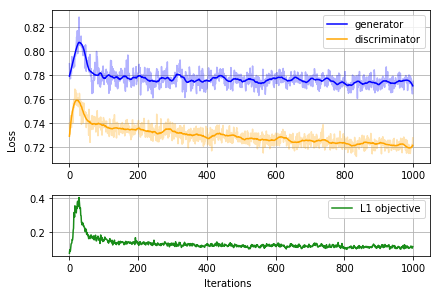

In [61]:
total_g_loss = np.array(log["g_loss"])[:,0]
total_d_loss = np.array(log["d_loss"])[:,0]
smoothed_tgl = src.smooth(np.array(log["g_loss"])[:,0])
smoothed_tdl = src.smooth(np.array(log["d_loss"])[:,0])
objective_loss = np.array(log["g_loss"])[:,1]

# plot 'em
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
a0.plot(total_g_loss, alpha=0.3, c="b")
a0.plot(total_d_loss, alpha=0.3, c="orange")
a0.plot(smoothed_tgl, c="b", label="generator")
a0.grid()
a0.plot(smoothed_tdl, c="orange", label="discriminator")
a0.legend()
a1.plot(objective_loss, alpha=0.9, c="green", label="L1 objective")
a1.grid()
a1.legend()
f.text(0.5, 0, 'Iterations', ha='center', va='center')
f.text(0, 0.5, 'Loss', ha='center', va='center', rotation='vertical')

f.tight_layout()
#f.savefig(name+'_curves.png')

## Save features

Save model history

In [37]:
np.save(name+"_log",log)

Save model weights

In [38]:
combined.save_weights(name+"_model.h5")

Load model and predict

In [ ]:
combined.load_weights("C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/ADL4CV_project/trainings/"+name+"/obj=1,ks=4/"+name+"_model.h5")

Predict future frames. Loads a 20 long sequence with 1000 sequence samples.

In [39]:
sequence_test = src.load_datasets(prediction=True)

Test data: (1000, 64, 64, 20)


In [40]:
sequence_test = src.augment_data(sequence_test[:100])

In [41]:
sequence_test.shape

(400, 64, 64, 20)

In [42]:
#test
predictions = {}
past_frames = sequence_test[...,0:past]
test_truth = sequence_test[...,past:past+1]

In [43]:
gen = combined.layers[1]

In [44]:
for t in range(sequence_test.shape[-1] - past):
    future = gen.predict(past_frames, batch_size=64)
    predictions[f"{t}"] = future
    past_frames = np.concatenate((past_frames[:,:,:,1:], predictions[f"{t}"]), axis=-1)
    test_truth = sequence_test[...,past+1+t:past+2+t]

Save example predictions

In [45]:
def save_examples(name, test, predictions_dict, past, samples=0):
    fig, axs = plt.subplots(len(samples)*2,past+len(predictions_dict.keys()), figsize=(32, 32))
    fig.subplots_adjust(wspace=0.3, hspace=0.0)
    for n in range(len(samples)):
        vmax = np.max(test[n,:,:,:past])
        vmin = 0
        print(test.shape)
        for i in range(past):
            im = axs[2*n,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax,vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Past frame {i+1}")
            src.colorbar(im)
        for i in range(past,past+len(predictions_dict.keys())):
            im = axs[2*n,i].imshow(predictions_dict[f"{i-past}"][samples[n], :,:,0], vmax=vmax, vmin=vmin)
            axs[2*n,i].axis('off')
            axs[2*n,i].set_title(f"Predicted frame {i-past+1}")
            src.colorbar(im)
            im = axs[2*n+1,i].imshow(test[samples[n], :,:,i], vmax=vmax, vmin=vmin)
            axs[2*n+1,i].axis('off')
            axs[2*n+1,i].set_title(f"Reference frame {i-past+1}")
            src.colorbar(im)
    fig.savefig(f"Plots/{name}_sequence_prediction.png")
    plt.close()


In [46]:
save_examples(name, sequence_test, predictions, past, samples=[33,46]) # 33, 46, 54

(400, 64, 64, 20)
(400, 64, 64, 20)


Calculate scores

In [47]:
list(predictions.keys())

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15']

In [48]:
norms = np.load(sys.path[0]+"/5min_long_pred_norms_compressed.npz")["arr_1"]

In [49]:
# *4 bc of augmentaion (it concats the frames so the 0th 1000th 2000th and 3000th are the same sample just rotated)
test_norms = list(norms)*4

In [50]:
#renormalize test samples
renormalized_test = np.array([sample * np.array(test_norms)[i] for i, sample in enumerate(sequence_test)])
renormalized_predictions = np.transpose((np.array([[sample * np.array(test_norms)[i] for i, sample in enumerate(predictions[key])] for key in predictions.keys()])[:,:,:,:,0]), (1,2,3,0))

In [51]:
renormalized_predictions.shape

(400, 64, 64, 16)

In [52]:
#thresholds: 2, 8, 42
thresholds = [10, 50, 100]
scores = {}
for t in range(renormalized_predictions.shape[-1]): # loop over the predictions (4)
    for s in thresholds: # make a dict entry for each threshold score
        scores[f"pred_{t+1}_threshold_{s}"] = src.calculate_skill_scores(renormalized_predictions[...,t:t+1],
                                                                                     renormalized_test[...,past+t:past+1+t],
                                                                                     x=renormalized_test[...,:past],
                                                                                     threshold=s)

C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:861: RuntimeWarning: invalid value encountered in true_divide
  scores["far"] = false_alarms/(hits+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:859: RuntimeWarning: invalid value encountered in true_divide
  scores["csi"] = hits/(hits+misses+false_alarms)
C:\Users\pkicsiny\Desktop\TUM\3\ADL4CV\ADL4CV_project\src.py:863: RuntimeWarning: invalid value encountered in true_divide
  scores["pod"] = hits/(hits+misses)


In [53]:
scores["pred_7_threshold_10"].keys()

dict_keys(['csi', 'far', 'pod', 'corr_to_truth', 'corr_to_input'])

In [54]:
np.save(name+"_scores",scores)

In [ ]:
name

In [ ]:
loaded_scores = np.load(sys.path[1]+"/"+name+"/"+name+"_scores.npy").item()

In [ ]:
list(loaded_scores.keys())

In [ ]:
np.mean((pd.Series(scores["pred_4_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(scores["pred_2_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(scores["pred_3_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
np.mean((pd.Series(scores["pred_4_threshold_100"]["corr_to_truth"]).dropna()))

In [ ]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss for a sample batch.
    The Wasserstein loss function is very simple to calculate. In a standard GAN, the discriminator
    has a sigmoid output, representing the probability that samples are real or generated. In Wasserstein
    GANs, however, the output is linear with no activation function! Instead of being constrained to [0, 1],
    the discriminator wants to make the distance between its output for real and generated samples as large as possible.
    The most natural way to achieve this is to label generated samples -1 and real samples 1, instead of the
    0 and 1 used in normal GANs, so that multiplying the outputs by the labels will give you the loss immediately.
    Note that the nature of this loss means that it can be (and frequently will be) less than 0."""
    return K.mean(y_true * y_pred)